# Time-dependent DMRG (tDMRG)

Here we will simulate the real-time evolution of quantum states in one-dimensional spin systems driven by time-independent Hamiltonians by using time-dependent density-matrix renormalization group (tDMRG).

In orde to do so we will consider the XY spin-1/2 chain. We will start with a chain of length N such that, at time t=0, the left part is up-polarized while the right part is down-polarized:

\begin{equation}
|\Psi(t=0)> = |\uparrow>_1|\uparrow>_1\cdots|\uparrow>_{N/2-1}|\uparrow>_{N/2}|\downarrow>_{N/2+1}|\downarrow>_{N/2+2}\cdots|\downarrow>_{N-1}|\downarrow>_{N}
\end{equation}

In such a way we are creating a domain wall in between sites N/2 and N/2 + 1.

After that, we will let the system evolve in time via $\exp{-i\hat{H}_{X}t}$: the domain wall wil be blurred out and spread. In the limit of $N\rightarrow\infty$, the exact solution of the magnetization is:

\begin{equation}
<\Psi(t)|\hat{S}_l^z|\Psi(t)> =-\frac{1}{2}\sum_{n=1-(l-N/2)}^{(l-N/2)-1}[J_n(t)]^2\quad\text{ for } j>N/2
\end{equation}

with $<\Psi(t)|\hat{S}_l^z|\Psi(t)>=-<\Psi(t)|\hat{S}_{N-l}^z|\Psi(t)>$ and $J_n(t)$ is the Bessel function of the first kind [D. Gobert et al, Phys. Rev. E 71, 036102 (2005)].

First of all we will compute $<\Psi(t)|\hat{S}_l^z|\Psi(t)>$ and then we will compare it with the exact result:

In [1]:
# Load all relevant modules
include("../JTensorNetwork.jl");
using PyPlot

In [2]:
# System parameters
J = +1; # Coupling strength
N = 50; # Number of sites in a chain

# DMRG parameters
Nkeep = 20;  # Bond dimension
dt = 1/20;   # discrete time step size
tmax = 20;   # maximum time

# Local operators
S,Id = getLocalSpace("Spin",1/2);

# XY Model
Hs = Vector{Union{Array{Float64,3}, Array{Float64,4}}}(undef, N-1);
for i in 1:length(Hs)
    Hs[i] = J*contract(S[:,1:2,:],3,[2],permutedims(conj(S[:,1:2,:]),[3 2 1]),3,[2]);
end

# Operator to measure magnetization
Sz = S[:,3,:];

# MPS initialization
M = Vector{Union{Array{ComplexF64,3},Array{Float64,3}}}(undef, N);
for itN in 1:N
    if itN <= N/2
        M[itN] = reshape([1.0,0.0],(1,2,1));
    else
        M[itN] = reshape([0.0,1.0],(1,2,1));
    end
end

# tDMRG
ts,M,Ovals,EE,dw = tDMRG(M,Hs,Sz,Nkeep,dt,tmax);

tDMRG: Real-time evolution with local measurements
N = 50, Nkeep = 20, dt = 0.05, tmax = 20.0 ( 400 steps)
1/12/2020 6:55:53 (GMT) | Transform the MPS into right-canonical form
1/12/2020 6:55:55 (GMT) | Trotter steps: start
1/12/2020 6:56:5 (GMT) | #40/400 : t = 2.0/20.0
1/12/2020 6:56:7 (GMT) | #80/400 : t = 4.0/20.0
1/12/2020 6:56:12 (GMT) | #120/400 : t = 6.0/20.0
1/12/2020 6:56:18 (GMT) | #160/400 : t = 8.0/20.0
1/12/2020 6:56:27 (GMT) | #200/400 : t = 10.0/20.0
1/12/2020 6:56:39 (GMT) | #240/400 : t = 12.0/20.0
1/12/2020 6:56:55 (GMT) | #280/400 : t = 14.0/20.0
1/12/2020 6:57:10 (GMT) | #320/400 : t = 16.0/20.0
1/12/2020 6:57:31 (GMT) | #360/400 : t = 18.0/20.0
1/12/2020 6:57:53 (GMT) | #400/400 : t = 20.0/20.0
Elapsed time: 120.56989097595215 s


The result Ovals is the matrix whose rows indicate the magnetization along the chain for every time steps. Since the time evolution involves complex numbers, Oval can be complex-valued in general. However, in this tutorial we measure magnetization, i.e., the expectation of the spin-z operator that is Hermitian, any imaginary part of Ovals here is numerical noise.

Indeed, we can check it:

In [3]:
mean(abs.(imag(Ovals[:])))

3.069481111893488e-17

It represents only numerical noise.

Now, let's plot the temporal evolution of the magnetization:

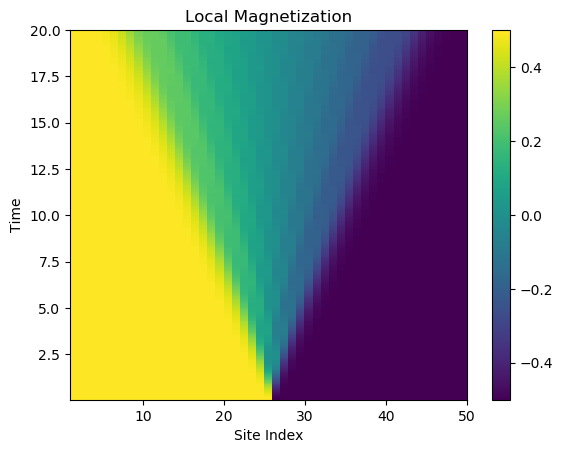

In [4]:
title("Local Magnetization");
xlabel("Site Index");
ylabel("Time");
pcolormesh(1:N,ts,real(Ovals));
colorbar();

The region in which the magnetization deviates from $\pm1/2$ propagates linearly in time and the velocity is approximately 1. The "wavefronts" of the blurred domain wall (or, say, magnetization fluctuation) don't reach the ends of the system within this time window.

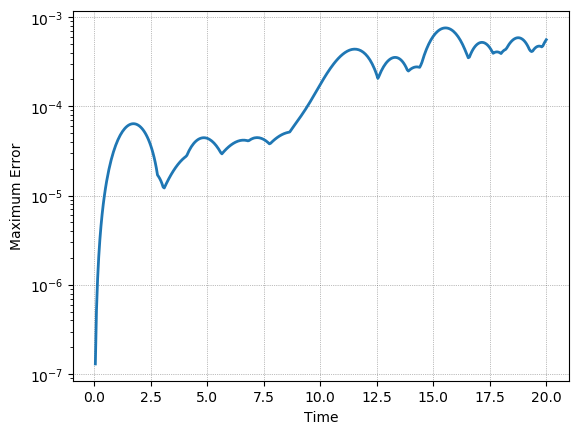

In [5]:
# exact values of magnetization in the infinite chain limit
# D. Gobert et al., Phys. Rev. E 71, 036102 (2005), Eq. (4)

# Bessel function of the 1st kind
using SpecialFunctions
fvals = zeros(length(ts),N-1);
for it in 1:size(fvals,2)
    for ij in 1:length(ts)
        fvals[ij,it] = (besselj(Int(it-N/2),ts[ij])).^2;
    end
end
fvals = -0.5*fvals;

# Exact values
Oexact = zeros(length(ts),Int(N/2));
for it in 1:Int(N/2)
    Oexact[:,it] = sum(fvals[:,Int(N/2-it+1):Int(it+N/2-1)],dims=2);
end
Oexact = hcat(-reverse(Oexact,dims=2),Oexact);

Oerr = maximum(abs.(Ovals-Oexact),dims=2);

ylabel("Maximum Error");
xlabel("Time");
grid(linewidth=0.5,color="black",linestyle="dotted",alpha=0.5);
semilogy(ts,Oerr,linewidth=2.0);

The error increases gradually with oscillations. The exact solution holds for the limit $N\rightarrow\infty$: it describes the system before the wavefronts of magnetization fluctuation reach the ends of the system.

The spread of magnetization fluctuation is accompained with the growth of the entanglement in the quantum state.
In order to see this, we plot the entanglement entropy of the MPS with respect to the bipartition at individual bonds for different times:

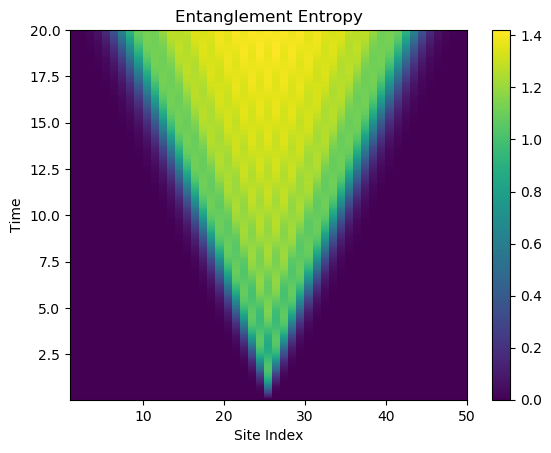

In [6]:
title("Entanglement Entropy");
xlabel("Site Index");
ylabel("Time");
pcolormesh(1:N,ts,EE[3:3:end,:]);
colorbar();

The entanglement entropy is the highest in the central region, and overall increases with time. As the entanglement grows, the bond dimension should also increase to fully describe the MPS. However, for the reason of computational cost, we typically fix the maximum bond dimension. Thus the smallest singular values need to be discarded after each singular value decomposition (SVD). The discarded weight is the sum of the squares of such discarded singular values after the SVD: the discarded weight measures the truncation error.

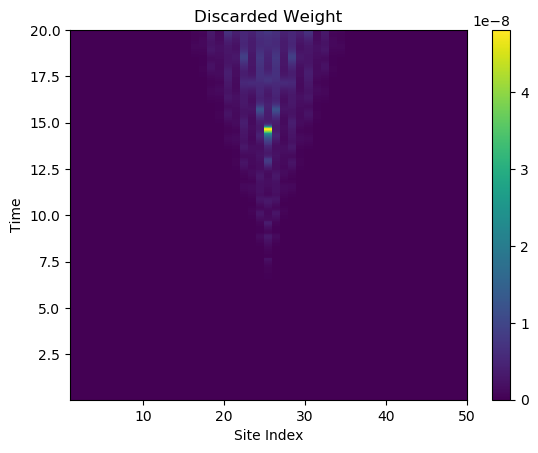

In [7]:
title("Discarded Weight");
xlabel("Site Index");
ylabel("Time");
pcolormesh(1:N,ts,reshape(sum(reshape(dw,(3,Int(size(dw,1)/3),size(dw,2))),dims=1),(Int(size(dw,1)/3),size(dw,2))));
colorbar();

The truncation error becomes finite in the region where the entanglement becomes larger. But within this time window, the discarded weight are negligibly small.

## Error Analysis

We want to see how the error changes with increasing/decreasing Nkeep and dt, with fixed tmax

In [8]:
# System parameters
J = +1; # Coupling strength
N = 50; # Number of sites in a chain

# DMRG parameters
Nkeep = [10, 20, 30];  # Bond dimension
dt = [1/40, 1/20, 1/10];   # discrete time step size
tmax = 20;   # maximum time

# Local operators
S,Id = getLocalSpace("Spin",1/2);

# XY Model
Hs = Vector{Union{Array{Float64,3}, Array{Float64,4}}}(undef, N-1);
for i in 1:length(Hs)
    Hs[i] = J*contract(S[:,1:2,:],3,[2],permutedims(conj(S[:,1:2,:]),[3 2 1]),3,[2]);
end

# Operator to measure magnetization
Sz = S[:,3,:];

# MPS initialization
M = Vector{Union{Array{ComplexF64,3},Array{Float64,3}}}(undef, N);
for itN in 1:N
    if itN <= N/2
        M[itN] = reshape([1.0,0.0],(1,2,1));
    else
        M[itN] = reshape([0.0,1.0],(1,2,1));
    end
end

# Result

ts    = Matrix{Any}(undef, length(Nkeep), length(dt));
Ovals = Matrix{Any}(undef, length(Nkeep), length(dt));
EE    = Matrix{Any}(undef, length(Nkeep), length(dt));
dw    = Matrix{Any}(undef, length(Nkeep), length(dt));

# tDMRG
for itN in 1:length(Nkeep)
    for itt in 1:length(dt)
        ts[itN,itt],M,Ovals[itN,itt],EE[itN,itt],dw[itN,itt] = tDMRG(M,Hs,Sz,Nkeep[itN],dt[itt],tmax);
        M = Vector{Union{Array{ComplexF64,3},Array{Float64,3}}}(undef, N);
        for ita in 1:N
            if ita <= N/2
                M[ita] = reshape([1.0,0.0],(1,2,1));
            else
                M[ita] = reshape([0.0,1.0],(1,2,1));
            end
        end
    end
end

tDMRG: Real-time evolution with local measurements
N = 50, Nkeep = 10, dt = 0.025, tmax = 20.0 ( 800 steps)
1/12/2020 6:58:42 (GMT) | Transform the MPS into right-canonical form
1/12/2020 6:58:42 (GMT) | Trotter steps: start
1/12/2020 6:58:45 (GMT) | #80/800 : t = 2.0/20.0
1/12/2020 6:58:49 (GMT) | #160/800 : t = 4.0/20.0
1/12/2020 6:58:54 (GMT) | #240/800 : t = 6.0/20.0
1/12/2020 6:58:59 (GMT) | #320/800 : t = 8.0/20.0
1/12/2020 6:59:6 (GMT) | #400/800 : t = 10.0/20.0
1/12/2020 6:59:14 (GMT) | #480/800 : t = 12.0/20.0
1/12/2020 6:59:25 (GMT) | #560/800 : t = 14.0/20.0
1/12/2020 6:59:35 (GMT) | #640/800 : t = 16.0/20.0
1/12/2020 6:59:46 (GMT) | #720/800 : t = 18.0/20.0
1/12/2020 6:59:57 (GMT) | #800/800 : t = 20.0/20.0
Elapsed time: 75.46504712104797 s
tDMRG: Real-time evolution with local measurements
N = 50, Nkeep = 10, dt = 0.05, tmax = 20.0 ( 400 steps)
1/12/2020 6:59:57 (GMT) | Transform the MPS into right-canonical form
1/12/2020 6:59:57 (GMT) | Trotter steps: start
1/12/2020 6:5

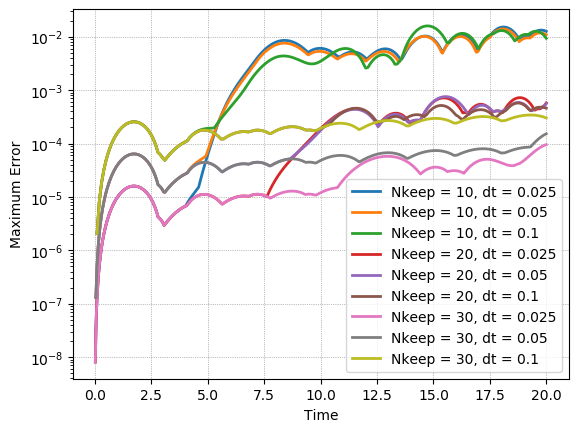

In [9]:
Oexact = Vector{Any}(undef, length(dt));
Oerr   = Matrix{Any}(undef, length(Nkeep), length(dt));;

for itt in 1:length(dt)
    fvals = zeros(length(ts[1,itt]),N-1);
    for it in 1:size(fvals,2)
        for ij in 1:length(ts[1,itt])
            fvals[ij,it] = (besselj(Int(it-N/2),ts[1,itt][ij])).^2;
        end
    end
    fvals = -0.5*fvals;
    
   # Exact values
    Oexact[itt] = zeros(length(ts[1,itt]),Int(N/2));
    for it in 1:Int(N/2)
        Oexact[itt][:,it] = sum(fvals[:,Int(N/2-it+1):Int(it+N/2-1)],dims=2);
    end
    Oexact[itt] = hcat(-reverse(Oexact[itt],dims=2),Oexact[itt]);
end

ylabel("Maximum Error");
xlabel("Time");
grid(linewidth=0.5,color="black",linestyle="dotted",alpha=0.5);

for itN in 1:length(Nkeep)
    for itt in 1:length(dt)
        Oerr[itN,itt] = maximum(abs.(Ovals[itN,itt]-Oexact[itt]),dims=2); 
        semilogy(ts[itN,itt],Oerr[itN,itt],linewidth=2.0,label="Nkeep = $(Nkeep[itN]), dt = $(dt[itt])");
    end
end

legend(loc="lower right");

For smaller values of Nkeep = 10, 20, there appear "runaway" times after which the error increases rapidly. This error is governed by the truncation error: small bond dimensions cannot fully capture the entanglement growth. So for smaller Nkeep, runaway time comes earlier, since it more suffers with the truncation error.
On the other hand, for larger value of Nkeep = 30, there is no runaway time visible within this time interval. Instead, the result for smaller time step size dt has lower error. That is, the error for Nkeep = 30 is governed
by the Trotter error that arises from discretizing the continuous time evolution operator $\exp{-i\hat{H}t}$ into several Trotter steps.

To focus on the truncation error, we plot the discarded weight: we sum over the discarded weights over the chain for every three Trotter steps, i.e. the time evolution over a time step dt.

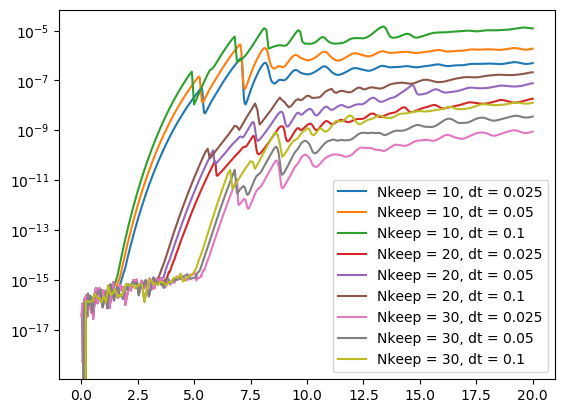

In [10]:
for itN in 1:length(Nkeep)
    for itt in 1:length(dt)
        # Sum over discarded weights along the chain, for three Trotter steps
        semilogy(ts[itN,itt],reshape(sum(sum(reshape(dw[itN,itt],(3,Int(size(dw[itN,itt],1)/3),size(dw[itN,itt],2))),dims=1),dims=3),(Int(size(dw[itN,itt],1)/3))),label="Nkeep = $(Nkeep[itN]), dt = $(dt[itt])");
    end
end

legend(loc="lower right");

The jumps of the discarded weights indicate that the bond truncation accompanied with the singular value decomposition (SVD) loses the information of the system. For larger Nkeep, the discarded weight remains small for longer period of time.

## Longer time evolution

We will now run tDMRG for a longer time:

In [11]:
# System parameters
J = +1; # Coupling strength
N = 50; # Number of sites in a chain

# DMRG parameters
Nkeep = 20;  # Bond dimension
dt = 1/20;   # discrete time step size
tmax = 80;   # maximum time

# Local operators
S,Id = getLocalSpace("Spin",1/2);

# XY Model
Hs = Vector{Union{Array{Float64,3}, Array{Float64,4}}}(undef, N-1);
for i in 1:length(Hs)
    Hs[i] = J*contract(S[:,1:2,:],3,[2],permutedims(conj(S[:,1:2,:]),[3 2 1]),3,[2]);
end

# Operator to measure magnetization
Sz = S[:,3,:];

# MPS initialization
M = Vector{Union{Array{ComplexF64,3},Array{Float64,3}}}(undef, N);
for itN in 1:N
    if itN <= N/2
        M[itN] = reshape([1.0,0.0],(1,2,1));
    else
        M[itN] = reshape([0.0,1.0],(1,2,1));
    end
end

# tDMRG
ts,M,Ovals,EE,dw = tDMRG(M,Hs,Sz,Nkeep,dt,tmax);

tDMRG: Real-time evolution with local measurements
N = 50, Nkeep = 20, dt = 0.05, tmax = 80.0 ( 1600 steps)
1/12/2020 7:18:21 (GMT) | Transform the MPS into right-canonical form
1/12/2020 7:18:21 (GMT) | Trotter steps: start
1/12/2020 7:18:38 (GMT) | #160/1600 : t = 8.0/80.0
1/12/2020 7:19:28 (GMT) | #320/1600 : t = 16.0/80.0
1/12/2020 7:20:57 (GMT) | #480/1600 : t = 24.0/80.0
1/12/2020 7:22:44 (GMT) | #640/1600 : t = 32.0/80.0
1/12/2020 7:24:29 (GMT) | #800/1600 : t = 40.0/80.0
1/12/2020 7:26:5 (GMT) | #960/1600 : t = 48.0/80.0
1/12/2020 7:27:44 (GMT) | #1120/1600 : t = 56.0/80.0
1/12/2020 7:29:22 (GMT) | #1280/1600 : t = 64.0/80.0
1/12/2020 7:31:2 (GMT) | #1440/1600 : t = 72.0/80.0
1/12/2020 7:32:40 (GMT) | #1600/1600 : t = 80.0/80.0
Elapsed time: 859.3608810901642 s


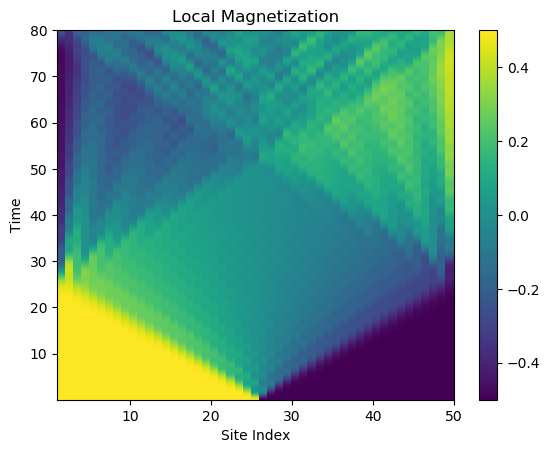

In [12]:
title("Local Magnetization");
xlabel("Site Index");
ylabel("Time");
pcolormesh(1:N,ts,real(Ovals));
colorbar();

We see that the wavefronts of magnetization fluctuation bounce back from the ends of the system and then manifest interference-like pattern. 

Since the exact solution which uses the Bessel functions covers before the wavefronts reache the ends of the system, we cannot make an error analysis based on the exact result. Instead, we can use the discarded weight as the measure of the truncation error:

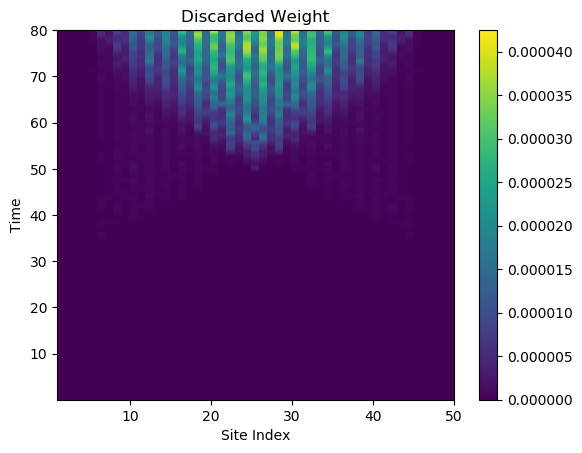

In [13]:
title("Discarded Weight");
xlabel("Site Index");
ylabel("Time");
pcolormesh(1:N,ts,reshape(sum(reshape(dw,(3,Int(size(dw,1)/3),size(dw,2))),dims=1),(Int(size(dw,1)/3),size(dw,2))));
colorbar();

There is another source of error: the Trotter error. The discarded weights cannot capture the Trotter error.
The discarded weight is larger for the bond and the time step at which the entaglement is large.

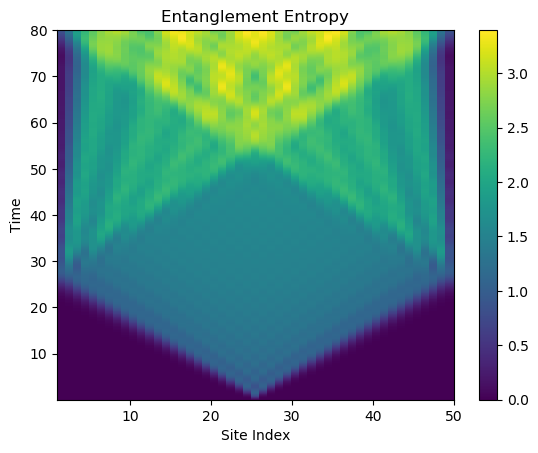

In [14]:
title("Entanglement Entropy");
xlabel("Site Index");
ylabel("Time");
pcolormesh(1:N,ts,EE[3:3:end,:]);
colorbar();

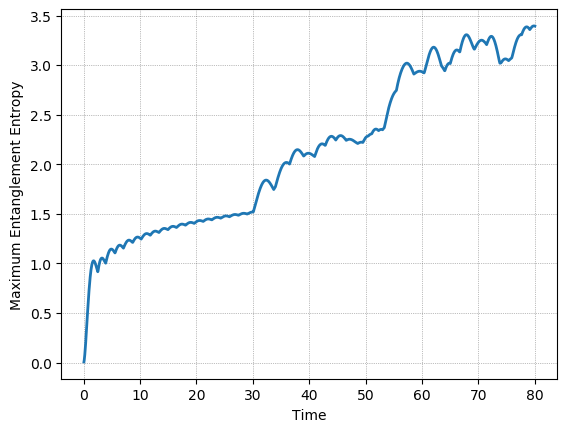

In [15]:
# Maximum Entanglement Entropy along the chain at each time step
ylabel("Maximum Entanglement Entropy");
xlabel("Time");
grid(linewidth=0.5,color="black",linestyle="dotted",alpha=0.5);
plot(ts,maximum(EE[3:3:end,:],dims=2),linewidth=2.0);

At later time steps, the entanglement entropy roughly speaking lineary grows with time. Such growth of the entanglement and the discarded weights indicates the necessity of larger bond dimensions, for better simulating the time evolution.

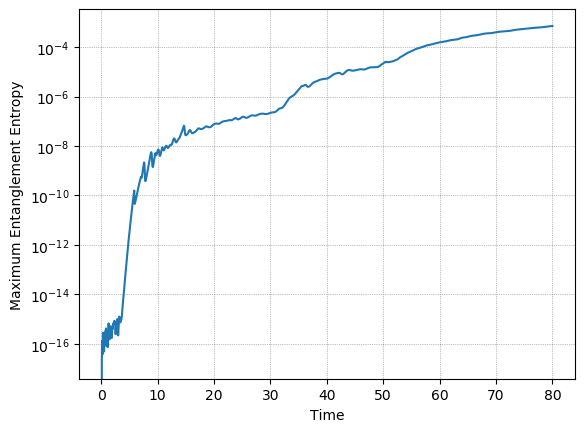

In [16]:
ylabel("Maximum Entanglement Entropy");
xlabel("Time");
grid(linewidth=0.5,color="black",linestyle="dotted",alpha=0.5);
semilogy(ts,reshape(sum(sum(reshape(dw,(3,Int(size(dw,1)/3),size(dw,2))),dims=1),dims=3),(Int(size(dw,1)/3))));

## Different initial state

We now consider a different initial state $|\Psi(t=0)>$, where all spins are down except for the n-th one which will be up:

\begin{equation}
|\Psi(t=0)> = \hat{S}^{+}_n|\downarrow,\dots,\downarrow>
\end{equation}

Also in this case we can find an analytic result:

\begin{equation}
<\Psi(t)|\hat{S}^z_{l}|\Psi(t)> = |\sum_{m=1}^N\frac{2}{N+1}\sin{(\frac{\pi m}{N+1}n})\sin{(\frac{\pi m}{N+1}l})\exp^{-it\cos{(\frac{\pi m}{N+1})}}|^2 - \frac{1}{2}
\end{equation}

In [17]:
# System parameters
J = +1; # Coupling strength
N = 50; # Number of sites in a chain

# DMRG parameters
Nkeep = 20;  # Bond dimension
dt = 1/20;   # discrete time step size
tmax = 80;   # maximum time

# Local operators
S,Id = getLocalSpace("Spin",1/2);

# XY Model
Hs = Vector{Union{Array{Float64,3}, Array{Float64,4}}}(undef, N-1);
for i in 1:length(Hs)
    Hs[i] = J*contract(S[:,1:2,:],3,[2],permutedims(conj(S[:,1:2,:]),[3 2 1]),3,[2]);
end

# Operator to measure magnetization
Sz = S[:,3,:];

# MPS initialization
M = Vector{Union{Array{ComplexF64,3},Array{Float64,3}}}(undef, N);
for itN in 1:N
    if itN == 10
        M[itN] = reshape([1.0,0.0],(1,2,1));
    else
        M[itN] = reshape([0.0,1.0],(1,2,1));
    end
end

# tDMRG
ts,M,Ovals,EE,dw = tDMRG(M,Hs,Sz,Nkeep,dt,tmax);

tDMRG: Real-time evolution with local measurements
N = 50, Nkeep = 20, dt = 0.05, tmax = 80.0 ( 1600 steps)
1/12/2020 7:41:39 (GMT) | Transform the MPS into right-canonical form
1/12/2020 7:41:39 (GMT) | Trotter steps: start
1/12/2020 7:41:43 (GMT) | #160/1600 : t = 8.0/80.0
1/12/2020 7:41:46 (GMT) | #320/1600 : t = 16.0/80.0
1/12/2020 7:41:51 (GMT) | #480/1600 : t = 24.0/80.0
1/12/2020 7:41:55 (GMT) | #640/1600 : t = 32.0/80.0
1/12/2020 7:42:0 (GMT) | #800/1600 : t = 40.0/80.0
1/12/2020 7:42:4 (GMT) | #960/1600 : t = 48.0/80.0
1/12/2020 7:42:9 (GMT) | #1120/1600 : t = 56.0/80.0
1/12/2020 7:42:13 (GMT) | #1280/1600 : t = 64.0/80.0
1/12/2020 7:42:17 (GMT) | #1440/1600 : t = 72.0/80.0
1/12/2020 7:42:21 (GMT) | #1600/1600 : t = 80.0/80.0
Elapsed time: 41.411015033721924 s


The magnetization fluctuation propagates from the site n and then is reflected from the boundaries:

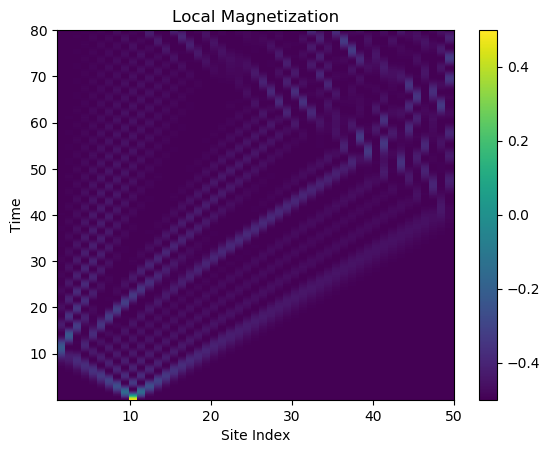

In [18]:
title("Local Magnetization");
xlabel("Site Index");
ylabel("Time");
pcolormesh(1:N,ts,real(Ovals));
colorbar();

Now we compute the error of tDMRG against the exact solution: in this case the exact solution can also describe the reflection of magnetization fluctuations.

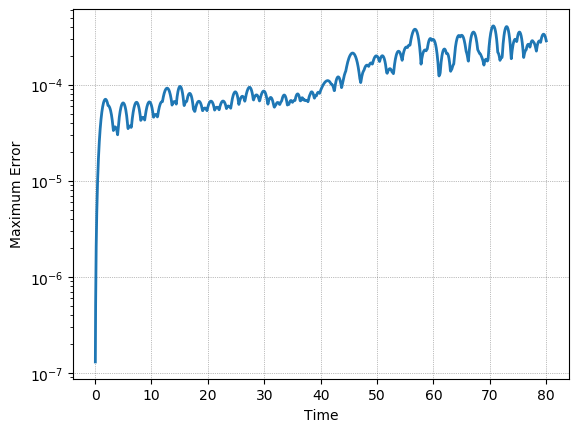

In [21]:
# Exact values
Oexact = zeros(length(ts),N);
n0 = 10;

for itt in 1:length(ts)
    for itN in 1:N
        Oexact[itt,itN] = -0.5+abs(sum((2/(N+1)).*sin.(pi.*(1:N).*n0./(N+1)).*sin.(pi.*(1:N).*itN./(N+1)).*exp.(-(1*im).*ts[itt].*cos.(pi.*(1:N)./(N+1))))).^2;
    end
end

Oerr = maximum(abs.(Ovals-Oexact),dims=2);

ylabel("Maximum Error");
xlabel("Time");
grid(linewidth=0.5,color="black",linestyle="dotted",alpha=0.5);
semilogy(ts,Oerr,linewidth=2.0);

In this case the error growth is much slower with respect to the previous ones: with this initial state the tDMRG simulation can go over longer in time with smaller error.

In order to explain this, we can study the entanglement entropy and the discarded weights:

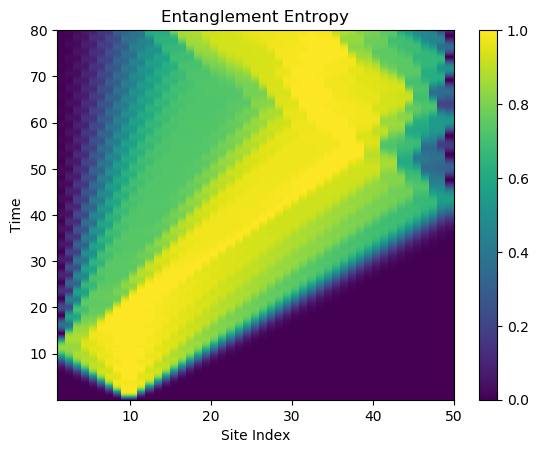

In [22]:
title("Entanglement Entropy");
xlabel("Site Index");
ylabel("Time");
pcolormesh(1:N,ts,EE[3:3:end,:]);
colorbar();

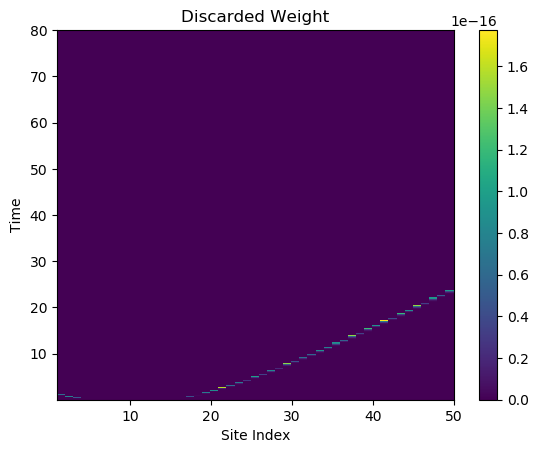

In [23]:
title("Discarded Weight");
xlabel("Site Index");
ylabel("Time");
pcolormesh(1:N,ts,reshape(sum(reshape(dw,(3,Int(size(dw,1)/3),size(dw,2))),dims=1),(Int(size(dw,1)/3),size(dw,2))));
colorbar();

In this case of the "only one up" initial state, the maximum entanglement entropy at each time instance is upper bounded by 1. And there are no discarded singular values, up to double precision!
It is because the effective Hilbert space for this time evolution is small. The total spin-z quantum number of the initlal state $S_z=1-N/2$ is conserved along the time evolution, since the Hamiltonian respects the conservation of $S_z$. Indeed, there are only N orthogonal states with $S_z=1-N/2$. So the tDMRG calculation of such case does not suffer the entanglement growth.
Therefore, the error in this example is solely due to the Trotter error.